# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)
## Data Exploration

**Imports**

In [92]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.dates as mdates

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera

In [93]:
# read parquets
OUT_DIR = "../out"        
DF_FILE       = "df.parquet"
DF_FULL_FILE  = "df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (85303, 10)
df_full shape: (96751, 10)


**Data Exploration**

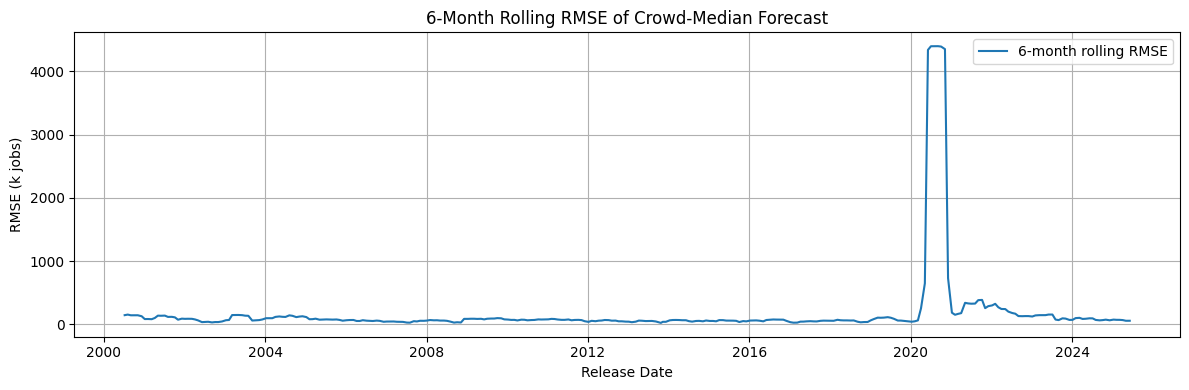

In [94]:
# Build one-row-per-release table of median forecast vs actual
median_vs_actual = (
    df_full.groupby("release_date")
           .agg(crowd_median=("forecast", "median"),
                actual      =("actual",   "first"))
           .dropna()
           .sort_index()
)

# Compute forecast error and rolling RMSE
median_vs_actual["err"] = median_vs_actual["crowd_median"] - median_vs_actual["actual"]

WINDOW = 6                       
median_vs_actual[f"rmse_{WINDOW}m"] = (
    median_vs_actual["err"]
      .rolling(WINDOW, min_periods=WINDOW)
      .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

# Plot rolling RMSE of the crowd median
plt.figure(figsize=(12, 4))
plt.plot(median_vs_actual.index,
         median_vs_actual[f"rmse_{WINDOW}m"],
         label=f"{WINDOW}-month rolling RMSE")

plt.title(f"{WINDOW}-Month Rolling RMSE of Crowd-Median Forecast")
plt.xlabel("Release Date")
plt.ylabel("RMSE (k jobs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

COVID (~2020-2022) should be filtered out if we want accuracy in naive point forecast

Contiguity windows:   0%|          | 0/3 [00:00<?, ?it/s]

6-mo tracking:   0%|          | 0/299 [00:00<?, ?it/s]

12-mo tracking:   0%|          | 0/293 [00:00<?, ?it/s]

24-mo tracking:   0%|          | 0/281 [00:00<?, ?it/s]

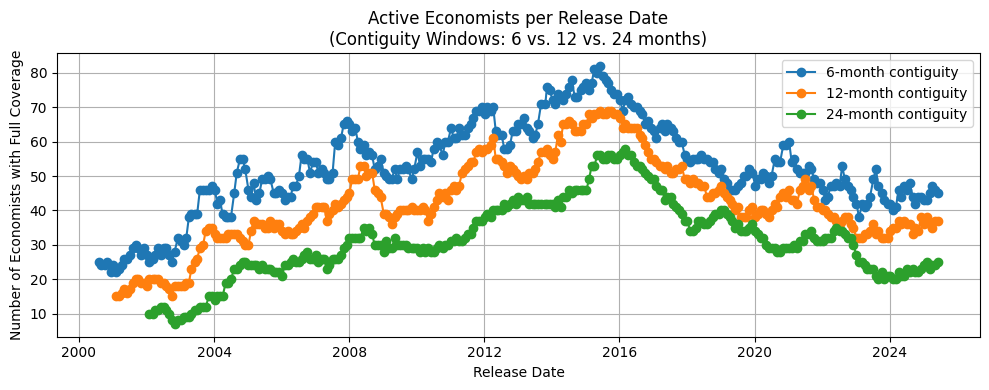

In [95]:
# prepare dates
dates = sorted(df_full["release_date"].unique())

contiguity_windows = [6, 12, 24]
active_counts = {}

for window in tqdm(contiguity_windows, desc="Contiguity windows"):
    counts = []
    for idx in tqdm(range(window, len(dates)),
                    desc=f"{window}-mo tracking",
                    leave=False):
        t            = dates[idx]
        window_dates = dates[idx-window:idx]
        hist         = df_full[df_full["release_date"].isin(window_dates)]
        valid        = (
            hist.groupby("economist")["forecast"]
                .apply(lambda s: s.notna().all())
        )
        counts.append((t, valid.sum()))
    active_counts[window] = pd.Series(
        [c for (_, c) in counts],
        index=[d for (d, _) in counts]
    )
    
plt.figure(figsize=(10, 4))
for window, series in active_counts.items():
    plt.plot(
        series.index,
        series.values,
        marker='o',
        label=f"{window}-month contiguity"
    )

plt.title("Active Economists per Release Date\n(Contiguity Windows: 6 vs. 12 vs. 24 months)")
plt.xlabel("Release Date")
plt.ylabel("Number of Economists with Full Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Visualize distribution of COVID-filtered dataframe**

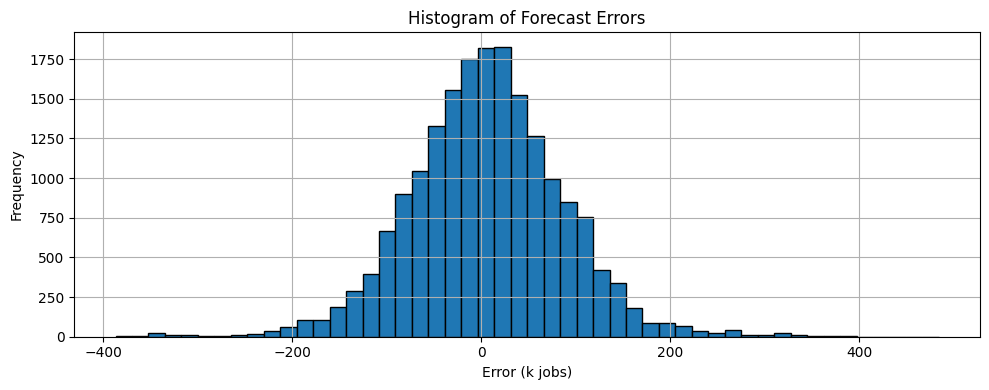

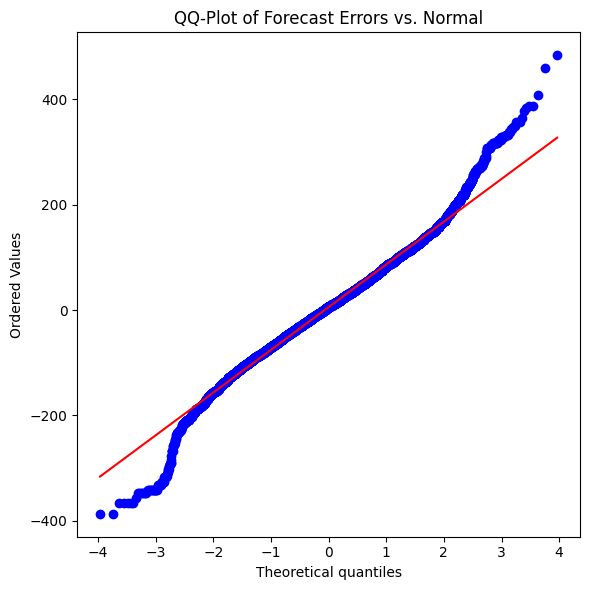

In [96]:
# Error distribution: histogram and QQ plot of forecast errors 
errors = df["error"].dropna().values

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=50, edgecolor="black")
plt.title("Histogram of Forecast Errors")
plt.xlabel("Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("QQ‐Plot of Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()

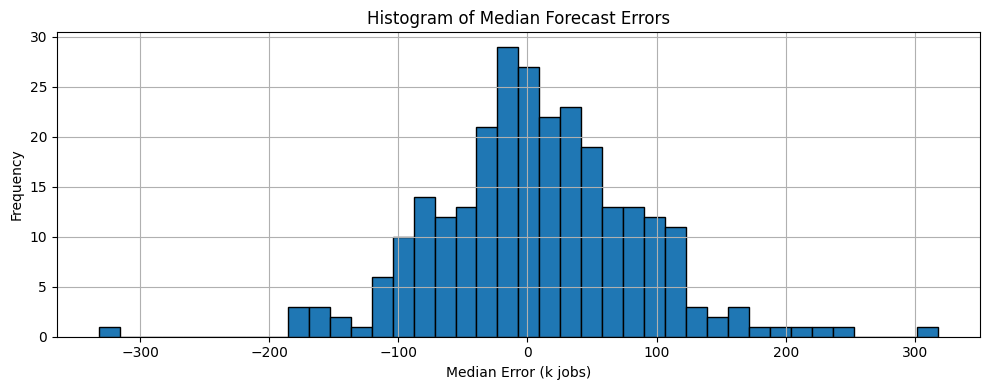

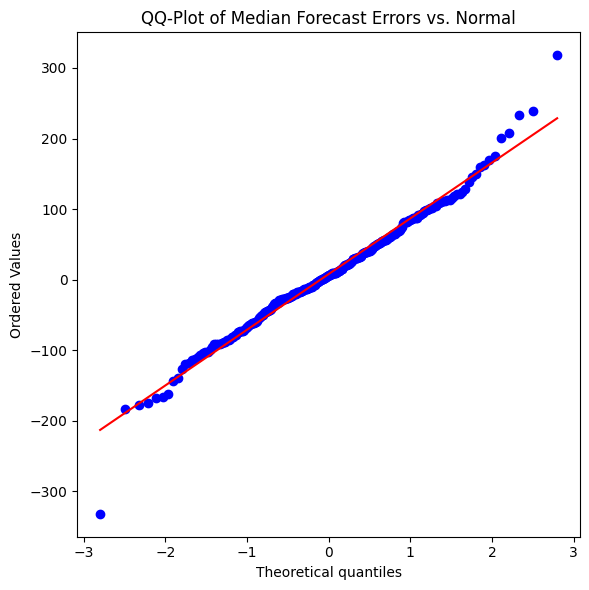

In [97]:
# Compute median forecast errors (one value per release)
median_errors = (
    df
    .drop_duplicates('release_date')  # keep one row per release
    .assign(median_err=lambda d: d['median_forecast'] - d['actual'])
    ['median_err']
    .values
)

# Histogram of median forecast errors
plt.figure(figsize=(10, 4))
plt.hist(median_errors, bins=40, edgecolor='black')
plt.title("Histogram of Median Forecast Errors")
plt.xlabel("Median Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# QQ‐plot of median errors against a Normal distribution
plt.figure(figsize=(6, 6))
stats.probplot(median_errors, dist='norm', plot=plt)
plt.title("QQ‐Plot of Median Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()


**Normality tests**

Unlikely given fat-tailed nature. We include this for completeness.

In [98]:
# --- Jarque-Bera on economist-level errors ----
jb_e_stat, jb_e_p = jarque_bera(errors)
print(f"Jarque–Bera (all economist errors) :  JB = {jb_e_stat:,.2f},  p = {jb_e_p:.4f}")

# --- Jarque-Bera on MEDIAN forecast errors -------------------------
jb_m_stat, jb_m_p = jarque_bera(median_errors)
print(f"Jarque–Bera (median errors)        :  JB = {jb_m_stat:,.2f},  p = {jb_m_p:.4f}")

if jb_m_p < 0.05:
    print("→ Reject normality of median errors at the 5 % level.")
else:
    print("→ Cannot reject normality of median errors at the 5 % level.")
    
    
# for reference: JB stat threshold for 5% threshold is approx. 6 

Jarque–Bera (all economist errors) :  JB = 1,963.77,  p = 0.0000
Jarque–Bera (median errors)        :  JB = 32.07,  p = 0.0000
→ Reject normality of median errors at the 5 % level.


## Student-t distribution test

KS and CvM goodness-of-fit test for student's t

Null: The sample comes from a fully-specified student-t CDF

KS emphasizes the worst mismatch, while CvM checks for a match in the overall shape. 

In [99]:
# fit parameters via MLE
nu_hat, loc_hat, scale_hat = st.t.fit(errors)

# Kolmogorov–Smirnov against fitted t
ks_stat, ks_p = st.kstest(errors, 't', args=(nu_hat, loc_hat, scale_hat))
print(f"K–S vs fitted t :  D = {ks_stat:.3f},  p = {ks_p:.4f}")

# Cramér–von Mises test (works for any callable CDF)
t_cdf = lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
cvm_res = st.cramervonmises(errors, t_cdf)
print(f"CvM statistic   :  W² = {cvm_res.statistic:.3f},  p = {cvm_res.pvalue:.4f}")

K–S vs fitted t :  D = 0.011,  p = 0.0209
CvM statistic   :  W² = 0.204,  p = 0.2602


Student-t is adequate to model errors in COVID-filtered dataframe. CvM denotes no meaningful deviation. KS rejection likely a large-sample artefact; visual inspection only shows miniscule departures.

**Overlay fitted t PDF (Forecast errors, median errors)**

- Use parameters we found previously via MLE to fit the student-t
- Check curve against histogram if parametric model under or overestimates mass 

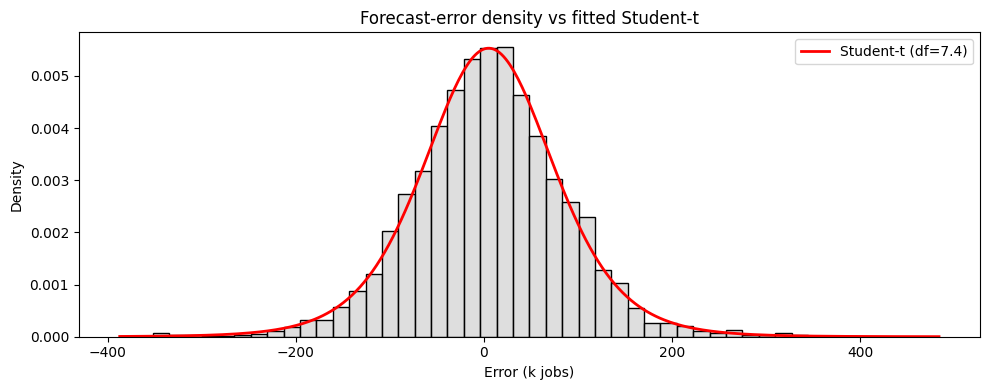

In [100]:
xgrid = np.linspace(errors.min(), errors.max(), 400)
pdf_t = st.t.pdf(xgrid, df=nu_hat, loc=loc_hat, scale=scale_hat)

plt.figure(figsize=(10,4))
sns.histplot(errors, bins=50, stat="density", edgecolor="k", color="lightgray")
plt.plot(xgrid, pdf_t, c="red", lw=2, label=f"Student-t (df={nu_hat:,.1f})")
plt.title("Forecast-error density vs fitted Student-t")
plt.xlabel("Error (k jobs)"); plt.ylabel("Density")
plt.legend(); plt.tight_layout(); plt.show()

No obvious bias present. Red t curve hugs grey bars well.

Let's try for median forecast errors:

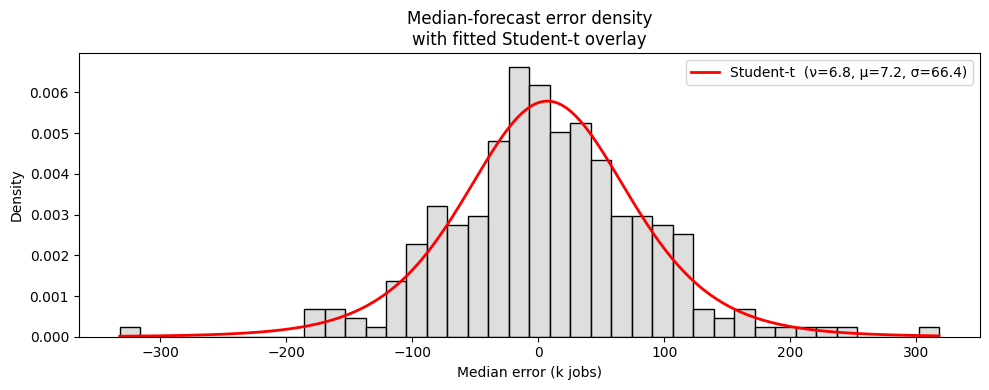

In [101]:
# MLE fit
nu_hat_median, loc_hat_median, scale_hat_median = st.t.fit(median_errors)

# Histogram + fitted Student-t PDF 
xgrid = np.linspace(median_errors.min(), median_errors.max(), 400)
pdf_t = st.t.pdf(xgrid,
                 df=nu_hat_median,
                 loc=loc_hat_median,
                 scale=scale_hat_median)

plt.figure(figsize=(10,4))
sns.histplot(median_errors,
             bins=40, stat="density",
             edgecolor="k", color="lightgray")
plt.plot(xgrid, pdf_t, c="red", lw=2,
         label=f"Student-t  (ν={nu_hat_median:.1f}, μ={loc_hat_median:.1f}, σ={scale_hat_median:.1f})")
plt.title("Median-forecast error density\nwith fitted Student-t overlay")
plt.xlabel("Median error (k jobs)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


**Tail-probability calibration plot**
- Two sided tail probability for each error 
- For every absolute error: Under the fitted student-t, what is the probability of seeing a value at least as extreme as this? 
- Output p-value between 0 and 1 
- Sorted p-values plotted against uniform [0,1] grid
- If fitted distribution were perfect, empirical CDF would hug the diagonal

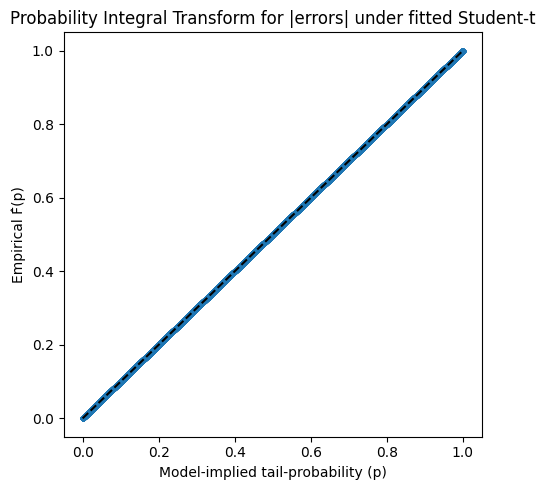

In [102]:
tail_pvals = 2*(1 - st.t.cdf(np.abs(errors), df=nu_hat, loc=0, scale=scale_hat))
tail_pvals.sort()
n = len(tail_pvals)

plt.figure(figsize=(5,5))
plt.plot(np.linspace(0,1,n), np.arange(1,n+1)/n, marker=".", ls="")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("Model-implied tail-probability (p)"); plt.ylabel("Empirical F̂(p)")
plt.title("Probability Integral Transform for |errors| under fitted Student-t")
plt.tight_layout(); plt.show()


**Contribution of tails to RMSE**

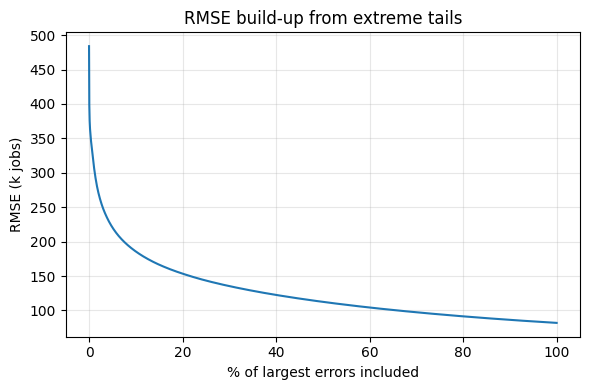

In [103]:
abs_err = np.abs(errors)
sorted_abs = np.sort(abs_err)[::-1]           # biggest first
cum_mse = np.cumsum(sorted_abs**2)
cum_rmse = np.sqrt(cum_mse / np.arange(1,len(errors)+1))

plt.figure(figsize=(6,4))
plt.plot(np.arange(1,len(errors)+1)/len(errors)*100, cum_rmse)
plt.xlabel("% of largest errors included"); plt.ylabel("RMSE (k jobs)")
plt.title("RMSE build-up from extreme tails"); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

Few gigantic errors dominate RMSE; heavy tail risk --> consider trimming (winsorize) or robust loss (student-t, Huber, quantile)

**Skewness vs. time**

- For every month t, compute sample skewness of previous 12 releases 
- Plot rolling window skewness 

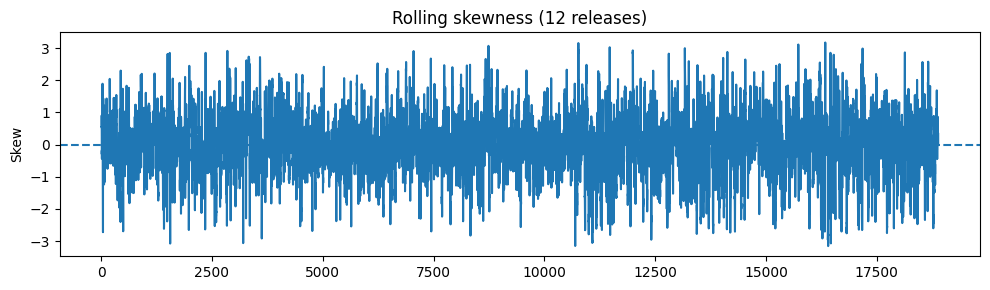

In [104]:
roll_skew = pd.Series(errors).rolling(12).skew()
roll_skew.plot(figsize=(10,3), title="Rolling skewness (12 releases)")
plt.axhline(0, ls="--"); plt.ylabel("Skew"); plt.tight_layout(); plt.show()

Forecasts centered correctly on average. Spikes represent fat-tail risk.

**Student-t implied parameters (forecast errors, median errors)**

In [105]:
nu, loc, scale = nu_hat, loc_hat, scale_hat       # from st.t.fit(...)
var   = scale**2 * nu / (nu-2)        if nu > 2 else np.inf
kurt  = 6 / (nu-4)                    if nu > 4 else np.inf

print("Student-t parameters:")
print(f"nu: {nu}")
print(f"loc: {loc}")
print(f"scale: {scale}\n")

print("Moments:")
print(f"Mean = {loc_hat}")
print(f"Var    = {var:6.2f}")
print(f"Skewness = 0 (Symmetric)")
print(f"Ex.Kurt= {kurt:6.2f}")

Student-t parameters:
nu: 7.418464693617684
loc: 5.192769902441414
scale: 69.74945424622365

Moments:
Mean = 5.192769902441414
Var    = 6660.69
Skewness = 0 (Symmetric)
Ex.Kurt=   1.76


In [106]:
# Median forecast errors --> fitted MLE params
print("Fitted Student-t parameters (MLE)")
print(f"ν  (degrees-of-freedom) : {nu_hat_median:6.2f}")
print(f"μ  (location / mean)    : {loc_hat_median:6.2f}  k jobs")
print(f"σ  (scale)              : {scale_hat_median:6.2f}  k jobs\n")

# Analytical moments 
mean_val  = loc_hat_median
variance  = (scale_hat_median**2 * nu_hat_median / (nu_hat_median - 2)
             if nu_hat_median > 2 else np.inf)
skewness  = 0                                      # symmetry
ex_kurt   = (6 / (nu_hat_median - 4)
             if nu_hat_median > 4 else np.inf)

print("Implied theoretical moments")
print(f"Mean            : {mean_val:6.2f}  k jobs")
print(f"Variance        : {variance:6.2f}")
print(f"Skewness        : {skewness}")
print(f"Excess kurtosis : {ex_kurt:6.2f}")


Fitted Student-t parameters (MLE)
ν  (degrees-of-freedom) :   6.77
μ  (location / mean)    :   7.24  k jobs
σ  (scale)              :  66.44  k jobs

Implied theoretical moments
Mean            :   7.24  k jobs
Variance        : 6263.97
Skewness        : 0
Excess kurtosis :   2.16


**Confidence Intervals**

Compute confidence intervals for point forecasts bases off student-t error distribution

In [107]:
def student_t_interval(point_forecast, nu=7.418464693617684, loc=5.192769902441414, scale=69.74945424622365, level=0.95):
    """Return lower, upper bounds of a (1-α) prediction interval."""
    q = st.t.ppf(1 - (1 - level)/2, df=nu)  # two-sided critical value
    lower = point_forecast + loc - q * scale
    upper = point_forecast + loc + q * scale
    return lower, upper

In [108]:
# example for the upcoming release
y_hat = 180        # example smart forecast
low, high = student_t_interval(
    y_hat, nu_hat, loc_hat, scale_hat, level=0.9
)
print(f"90 % interval: ({low:.1f},{high:.1f}) k")

90 % interval: (54.2,316.2) k
